In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
% matplotlib inline

In [2]:
years = [2012, 2013, 2014]

In [3]:
df = pd.read_csv('lucentisavastin.csv')
del df['year2']
df.head()

,npi,hcpcs_code,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,year
0,1366492365,J2778,865.0,57,183,2014
1,1245231216,J2778,1955.0,82,357,2012
2,1205832615,J2778,2498.0,123,502,2012
3,1083871974,J2778,728.0,42,168,2013
4,1245243013,J2778,2670.0,98,534,2012


In [4]:
providers = {2012: {}, 2013: {}, 2014: {}}
def process(row):
    npi = row['npi']
    hcpcs_code = row['hcpcs_code']
    year = row['year']
    if npi not in providers[year]:
        providers[year][npi] = {'J2778': 0, 'J9035': 0, 'sum': 0}
    providers[year][npi][hcpcs_code] += row['bene_unique_cnt']
    providers[year][npi]['sum'] += row['bene_unique_cnt']

In [5]:
a = df.apply(process, axis=1)

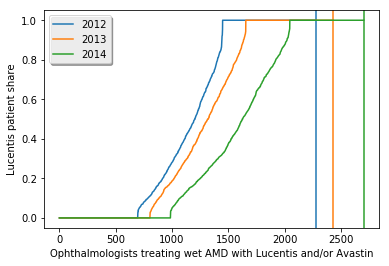

In [12]:
lucentis_percentages = {2012: {}, 2013: {}, 2014: {}}
def percentage(row):
    npi = row['npi']
    year = row['year']
    lucentis_percentages[year][npi] = providers[year][npi]['J2778'] * 1. / providers[year][npi]['sum']

a = df.apply(percentage, axis=1)
plt.clf()
for year in years:
    plt.plot(sorted(lucentis_percentages[year].values()), label=str(year))
    plt.axvline(x=len(lucentis_percentages[year]), color='C{}'.format(year - 2012))
plt.legend(fancybox=True, shadow=True)
plt.xlabel('Ophthalmologists treating wet AMD with Lucentis and/or Avastin')
plt.ylabel('Lucentis patient share')
plt.savefig('lucentispatientshare.pdf')

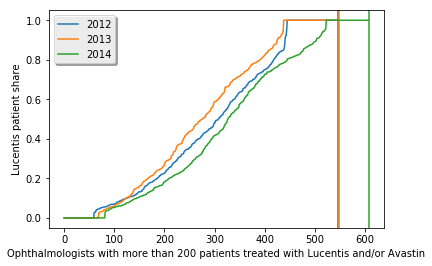

In [10]:
data = []
lucentis_prop = {}
plt.clf()
for year in years:
    year_df = pd.DataFrame.from_dict(providers[year], orient='index')
    year_df = year_df[year_df['sum'] >= 200]
    year_df['lucentis_prop'] = year_df['J2778'] * 1. / year_df['sum']
    del year_df['sum']
    year_df['J2778'] = year_df['J2778'] > 0
    year_df['J9035'] = year_df['J9035'] > 0
#     print year
#     print year_df.groupby(['J9035', 'J2778']).size()
    data.append(list(year_df.groupby(['J9035', 'J2778']).size()))
    lucentis_prop[year] = year_df['lucentis_prop']
    plt.plot(sorted(list(lucentis_prop[year])), label=str(year))
    plt.axvline(x=len(lucentis_prop[year]) + int(year == 2013), color='C{}'.format(year - 2012))

final_counts = pd.DataFrame(data, index=years, columns=['Lucentis (J2778) only', 
                                                        'Avastin (J9035) only', 
                                                        'Both'])

plt.legend(fancybox=True, shadow=True)
plt.xlabel('Ophthalmologists with more than 200 patients treated with Lucentis and/or Avastin')
plt.ylabel('Lucentis patient share')
plt.savefig('lucentispatientshare200.pdf')

In [9]:
len(lucentis_prop[2012]), len(lucentis_prop[2013])

(547, 547)

In [83]:
final_props = final_counts.div(final_counts.sum(axis=1), axis=0)

In [84]:
x = range(3)

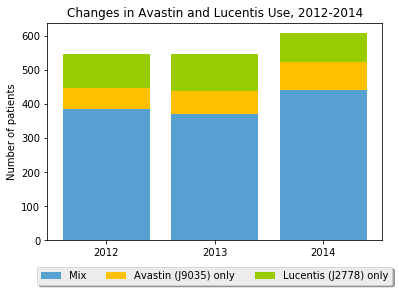

In [117]:
plt.clf()
plt.bar(x, 
        final_counts['Both'], 
        color='#56a0d2', 
        label='Mix')
plt.bar(x, 
        final_counts['Avastin (J9035) only'], 
        color='#ffc000', 
        label='Avastin (J9035) only',
        bottom=final_counts['Both'])
plt.bar(x, 
        final_counts['Lucentis (J2778) only'], 
        color='#99cc00', 
        label='Lucentis (J2778) only',
        bottom=final_counts['Both'] + final_counts['Avastin (J9035) only'])

plt.xticks(x, years)
plt.ylabel('Number of patients')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)
plt.title('Changes in Avastin and Lucentis Use, 2012-2014')
plt.savefig('lucentisavastinplot.pdf', bbox_inches='tight', pad_inches=0.2)

In [116]:
with open('lucentisavastindata.tex', 'wb') as f:
    f.write((100 * final_props).to_latex(float_format='%.1f', column_format='cccc'))